# Generate a Gaussian mixture dataset

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

# Parameters for class L=0
m0 = np.array([-1, -1, -1, -1])
C0 = np.array([[2, -0.5, 0.3, 0],
               [-0.5, 1, -0.5, 0],
               [0.3, -0.5, 1, 0],
               [0, 0, 0, 2]])

# Parameters for class L=1
m1 = np.array([1, 1, 1, 1])
C1 = np.array([[1, 0.3, -0.2, 0],
               [0.3, 2, 0.3, 0],
               [-0.2, 0.3, 1, 0],
               [0, 0, 0, 3]])

# Class priors
P_L0 = 0.35
P_L1 = 0.65

# Number of samples
num_samples = 10000

# Generate class labels L (0 or 1) based on the priors
labels = np.random.choice([0, 1], size=num_samples, p=[P_L0, P_L1])

# Initialize an empty array to store the generated samples
samples = np.zeros((num_samples, 4))

# Generate samples for each class based on the Gaussian distributions
for i in range(num_samples):
    if labels[i] == 0:
        samples[i] = multivariate_normal.rvs(mean=m0, cov=C0)
    else:
        samples[i] = multivariate_normal.rvs(mean=m1, cov=C1)

# Save the generated samples and labels to a file
np.savez('gaussian_mixture_samples.npz', samples=samples, labels=labels)

print(f"Generated {num_samples} samples and saved to 'gaussian_mixture_samples.npz'")


Generated 10000 samples and saved to 'gaussian_mixture_samples.npz'


In [4]:
samples, labels

(array([[ 1.21702054,  0.42134373,  0.10965336,  1.14882005],
        [ 3.86235031,  4.40286043,  2.04268341,  2.08843631],
        [-0.39410192, -0.41088299, -2.98079201, -1.47109445],
        ...,
        [-0.69416581, -2.65615592,  1.06310199, -3.30495517],
        [ 0.69585596, -1.63946255,  0.50437631,  2.381229  ],
        [ 0.26764186,  4.44565221,  2.03894145,  0.79276422]]),
 array([1, 1, 0, ..., 1, 1, 1]))

## Part A

In [12]:
# Import necessary libraries
import numpy as np
from scipy.stats import multivariate_normal

# Load the generated data from part 1
data = np.load('gaussian_mixture_samples.npz')
samples = data['samples']
labels = data['labels']

# Compute the likelihoods p(x|L=0) and p(x|L=1) for each sample
p_x_given_L0 = multivariate_normal.pdf(samples, mean=m0, cov=C0)
p_x_given_L1 = multivariate_normal.pdf(samples, mean=m1, cov=C1)

# Likelihood ratio for each sample
likelihood_ratio = p_x_given_L1 / p_x_given_L0

# Print the answer for step 1
print("Minimum Expected Risk Classification Rule")
print("Likelihood ratio computed as p(x|L=1) / p(x|L=0) for each sample.")
print(f"Sample likelihood ratios: {likelihood_ratio}")  # Print the first 5 likelihood ratios as a sample


Minimum Expected Risk Classification Rule
Likelihood ratio computed as p(x|L=1) / p(x|L=0) for each sample.
Sample likelihood ratios: [3.51761361e+02 1.89713759e+20 7.80182270e-05 ... 2.50332324e-02
 7.99132323e+00 1.64115809e+16]


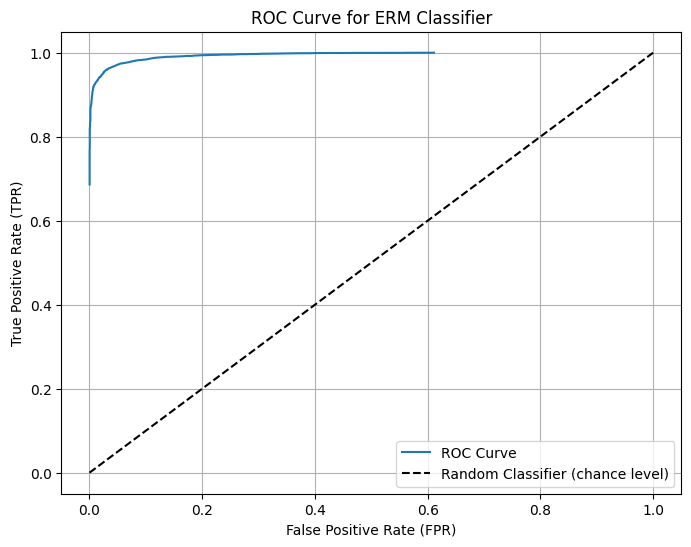

Step 2: ROC Curve computed and plotted.


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Set up a range of gamma (threshold) values to sweep through
gamma_values = np.logspace(-3, 3, num=500)  # 500 gamma values from 10^-3 to 10^3

# Lists to store true positive and false positive rates for the ROC curve
tpr_values = []  # True Positive Rate (P(D=1 | L=1))
fpr_values = []  # False Positive Rate (P(D=1 | L=0))

# Iterate through each gamma and compute TPR and FPR
for gamma in gamma_values:
    # Apply the likelihood ratio test: decide class based on threshold gamma
    decisions = (likelihood_ratio > gamma).astype(int)

    # True positives: D=1 and L=1
    tp = np.sum((decisions == 1) & (labels == 1))
    fn = np.sum((decisions == 0) & (labels == 1))
    tpr = tp / (tp + fn)  # True positive rate

    # False positives: D=1 and L=0
    fp = np.sum((decisions == 1) & (labels == 0))
    tn = np.sum((decisions == 0) & (labels == 0))
    fpr = fp / (fp + tn)  # False positive rate

    tpr_values.append(tpr)
    fpr_values.append(fpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (chance level)')
plt.title('ROC Curve for ERM Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print the answer for step 2
print("Step 2: ROC Curve computed and plotted.")
# print(f"TPR values (sample): {np.array(tpr_values)}")
# print(f"FPR values (sample): {np.array(fpr_values)}")


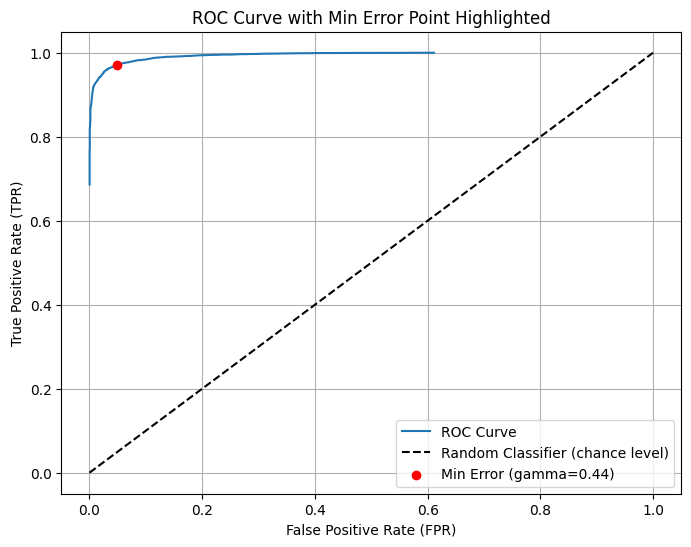

Step 3: Minimizing the Probability of Error
The minimum probability of error is 0.0358 at gamma = 0.4419
Corresponding FPR: 0.0494, TPR: 0.9715


Comparison of Empirically Selected Gamma and Theoretical Optimal Gamma
Empirically selected gamma (from ROC curve) = 0.4419
Theoretically optimal gamma (from priors) = 0.5385
The empirical gamma differs from the theoretical optimal gamma.


In [19]:
# Step 3: Find the gamma that minimizes the probability of error
# P(error; gamma) = P(D=1 | L=0) * P(L=0) + P(D=0 | L=1) * P(L=1)
P_L0 = 0.35
P_L1 = 0.65

# Initialize an empty list to store the probability of error for each gamma
errors = []

# Calculate the error for each gamma value
for i, gamma in enumerate(gamma_values):
    # False positive rate and false negative rate (1 - True positive rate)
    fpr = fpr_values[i]
    fnr = 1 - tpr_values[i]

    # Probability of error for this gamma
    p_error = fpr * P_L0 + fnr * P_L1
    errors.append(p_error)

# Find the index of the minimum error
min_error_idx = np.argmin(errors)
min_error_gamma = gamma_values[min_error_idx]
min_error_value = errors[min_error_idx]

# Plot the ROC curve again, but highlight the point of minimum error
plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (chance level)')
plt.scatter(fpr_values[min_error_idx], tpr_values[min_error_idx], color='red', label=f'Min Error (gamma={min_error_gamma:.2f})', zorder=5)
plt.title('ROC Curve with Min Error Point Highlighted')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print the answer for step 3
print("Step 3: Minimizing the Probability of Error")
print(f"The minimum probability of error is {min_error_value:.4f} at gamma = {min_error_gamma:.4f}")
print(f"Corresponding FPR: {fpr_values[min_error_idx]:.4f}, TPR: {tpr_values[min_error_idx]:.4f}")

# Compute the theoretical optimal gamma
gamma_opt_theoretical = P_L0 / P_L1

# Print the comparison
print("\n")
print("Comparison of Empirically Selected Gamma and Theoretical Optimal Gamma")
print(f"Empirically selected gamma (from ROC curve) = {min_error_gamma:.4f}")
print(f"Theoretically optimal gamma (from priors) = {gamma_opt_theoretical:.4f}")

# Compare the results
if np.isclose(min_error_gamma, gamma_opt_theoretical, atol=0.01):
    print("The empirical gamma is very close to the theoretical optimal gamma.")
else:
    print("The empirical gamma differs from the theoretical optimal gamma.")


## Part B

In [20]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Load the generated data
data = np.load('gaussian_mixture_samples.npz')
samples = data['samples']
labels = data['labels']

# True mean vectors from Part A
m0 = np.array([-1, -1, -1, -1])
m1 = np.array([1, 1, 1, 1])

# True covariance matrices from Part A
C0_true = np.array([[2, -0.5, 0.3, 0],
                    [-0.5, 1, -0.5, 0],
                    [0.3, -0.5, 1, 0],
                    [0, 0, 0, 2]])

C1_true = np.array([[1, 0.3, -0.2, 0],
                    [0.3, 2, 0.3, 0],
                    [-0.2, 0.3, 1, 0],
                    [0, 0, 0, 3]])

# Naive Bayesian assumption: use diagonal covariance matrices
# Extract the diagonal entries (variances) for each class
C0_naive = np.diag(np.diag(C0_true))  # Diagonal matrix for class L=0
C1_naive = np.diag(np.diag(C1_true))  # Diagonal matrix for class L=1

# Print the diagonal covariance matrices to verify
print("Diagonal covariance matrix for class L=0 (Naive Bayes assumption):")
print(C0_naive)
print("Diagonal covariance matrix for class L=1 (Naive Bayes assumption):")
print(C1_naive)


Diagonal covariance matrix for class L=0 (Naive Bayes assumption):
[[2. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 2.]]
Diagonal covariance matrix for class L=1 (Naive Bayes assumption):
[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 3.]]


In [22]:
# Class priors
P_L0 = 0.35
P_L1 = 0.65

# Compute the likelihoods p(x|L=0) and p(x|L=1) using the Naive Bayes assumption
p_x_given_L0_naive = multivariate_normal.pdf(samples, mean=m0, cov=C0_naive)
p_x_given_L1_naive = multivariate_normal.pdf(samples, mean=m1, cov=C1_naive)

# Likelihood ratio for each sample under Naive Bayes assumption
likelihood_ratio_naive = p_x_given_L1_naive / p_x_given_L0_naive

# Print some sample likelihood ratios
print(f"Sample likelihood ratios (Naive Bayes assumption): {likelihood_ratio_naive}")


Sample likelihood ratios (Naive Bayes assumption): [2.70824011e+01 3.20203944e+08 2.41014784e-04 ... 3.99848265e-02
 1.19619104e+01 1.72700163e+07]


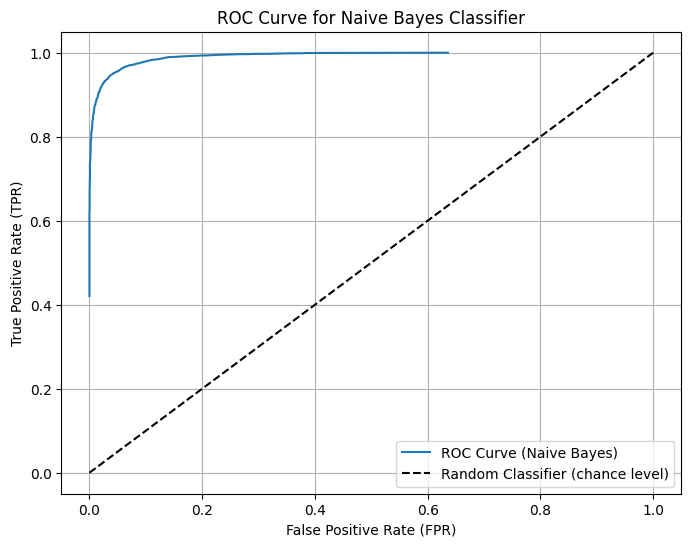

ROC Curve for Naive Bayes classifier plotted.


In [23]:
# Set up a range of gamma (threshold) values to sweep through
gamma_values = np.logspace(-3, 3, num=500)  # 500 gamma values from 10^-3 to 10^3

# Lists to store true positive and false positive rates for the ROC curve
tpr_values_naive = []  # True Positive Rate (P(D=1 | L=1))
fpr_values_naive = []  # False Positive Rate (P(D=1 | L=0))

# Iterate through each gamma and compute TPR and FPR using Naive Bayes assumption
for gamma in gamma_values:
    decisions_naive = (likelihood_ratio_naive > gamma).astype(int)

    # True positives: D=1 and L=1
    tp = np.sum((decisions_naive == 1) & (labels == 1))
    fn = np.sum((decisions_naive == 0) & (labels == 1))
    tpr_naive = tp / (tp + fn)  # True positive rate

    # False positives: D=1 and L=0
    fp = np.sum((decisions_naive == 1) & (labels == 0))
    tn = np.sum((decisions_naive == 0) & (labels == 0))
    fpr_naive = fp / (fp + tn)  # False positive rate

    tpr_values_naive.append(tpr_naive)
    fpr_values_naive.append(fpr_naive)

# Plot the ROC curve for the Naive Bayes assumption
plt.figure(figsize=(8, 6))
plt.plot(fpr_values_naive, tpr_values_naive, label='ROC Curve (Naive Bayes)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (chance level)')
plt.title('ROC Curve for Naive Bayes Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print the ROC curve details
print("ROC Curve for Naive Bayes classifier plotted.")


In [24]:
# Step 4: Find the gamma that minimizes the probability of error using Naive Bayes assumption
errors_naive = []

# Calculate the error for each gamma value using Naive Bayes assumption
for i, gamma in enumerate(gamma_values):
    # False positive rate and false negative rate (1 - True positive rate)
    fpr_naive = fpr_values_naive[i]
    fnr_naive = 1 - tpr_values_naive[i]

    # Probability of error for this gamma
    p_error_naive = fpr_naive * P_L0 + fnr_naive * P_L1
    errors_naive.append(p_error_naive)

# Find the index of the minimum error
min_error_idx_naive = np.argmin(errors_naive)
min_error_gamma_naive = gamma_values[min_error_idx_naive]
min_error_value_naive = errors_naive[min_error_idx_naive]

# Print the results
print("Step 4: Minimizing the Probability of Error with Naive Bayes Assumption")
print(f"The minimum probability of error (Naive Bayes) is {min_error_value_naive:.4f} at gamma = {min_error_gamma_naive:.4f}")


Step 4: Minimizing the Probability of Error with Naive Bayes Assumption
The minimum probability of error (Naive Bayes) is 0.0438 at gamma = 0.4298


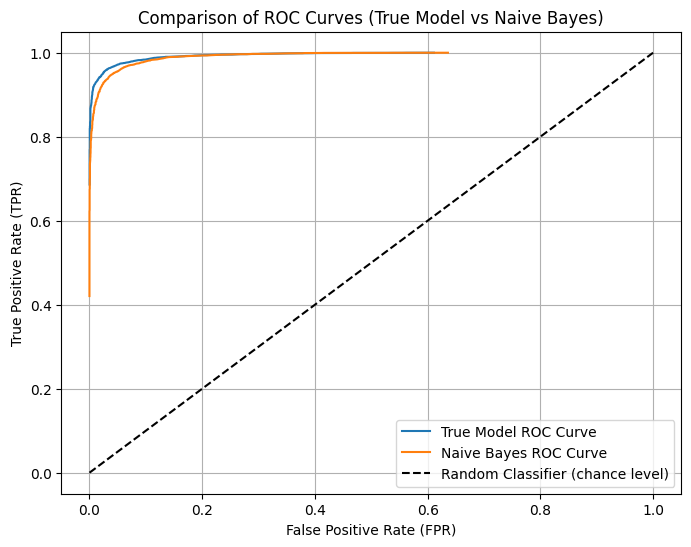

Comparison of Minimum Probability of Error
True Model: Minimum probability of error = 0.0358 at gamma = 0.4419
Naive Bayes Model: Minimum probability of error = 0.0438 at gamma = 0.4298
Difference in minimum error between True Model and Naive Bayes: 0.0080
The Naive Bayes assumption had a minimal impact on the performance in this case.


In [25]:
# Plot ROC Curves for both models to compare
plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, label='True Model ROC Curve')
plt.plot(fpr_values_naive, tpr_values_naive, label='Naive Bayes ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (chance level)')
plt.title('Comparison of ROC Curves (True Model vs Naive Bayes)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print minimum error comparison
print("Comparison of Minimum Probability of Error")
print(f"True Model: Minimum probability of error = {min(errors):.4f} at gamma = {gamma_values[np.argmin(errors)]:.4f}")
print(f"Naive Bayes Model: Minimum probability of error = {min_error_value_naive:.4f} at gamma = {min_error_gamma_naive:.4f}")

# Analyze if the error rates differ significantly
error_diff = abs(min(errors) - min_error_value_naive)
print(f"Difference in minimum error between True Model and Naive Bayes: {error_diff:.4f}")

# Conclusion
if error_diff > 0.01:
    print("The Naive Bayes assumption negatively impacted the performance, leading to a higher probability of error.")
else:
    print("The Naive Bayes assumption had a minimal impact on the performance in this case.")


## Part C

In [26]:
import numpy as np

# Load the generated data
data = np.load('gaussian_mixture_samples.npz')
samples = data['samples']
labels = data['labels']

# Separate the samples by class
class_0_samples = samples[labels == 0]
class_1_samples = samples[labels == 1]

# Estimate the means (sample average for each class)
mean_0 = np.mean(class_0_samples, axis=0)
mean_1 = np.mean(class_1_samples, axis=0)

# Estimate the covariances (sample covariance for each class)
cov_0 = np.cov(class_0_samples, rowvar=False)
cov_1 = np.cov(class_1_samples, rowvar=False)

# Print the estimated means and covariances
print("Estimated mean for class 0:", mean_0)
print("Estimated mean for class 1:", mean_1)
print("Estimated covariance for class 0:\n", cov_0)
print("Estimated covariance for class 1:\n", cov_1)


Estimated mean for class 0: [-0.97885076 -1.0237032  -0.9936786  -0.98522708]
Estimated mean for class 1: [0.98877577 1.01837441 1.00133738 1.03811884]
Estimated covariance for class 0:
 [[ 2.05628253 -0.50954691  0.30881279  0.02713176]
 [-0.50954691  0.99377434 -0.50324397 -0.0270095 ]
 [ 0.30881279 -0.50324397  1.01671457  0.02585526]
 [ 0.02713176 -0.0270095   0.02585526  1.93776272]]
Estimated covariance for class 1:
 [[ 0.98596894  0.28232123 -0.17598996 -0.00444704]
 [ 0.28232123  2.00259907  0.33323045 -0.02692974]
 [-0.17598996  0.33323045  1.00285683  0.03258915]
 [-0.00444704 -0.02692974  0.03258915  2.96640964]]


In [27]:
# Compute the within-class scatter matrix (S_W)
S_W = cov_0 + cov_1

# Compute the between-class difference in means
mean_diff = mean_1 - mean_0

# Compute the Fisher LDA weight vector
w_LDA = np.linalg.inv(S_W).dot(mean_diff)

# Print the Fisher LDA weight vector
print("Fisher LDA projection vector (w_LDA):", w_LDA)


Fisher LDA projection vector (w_LDA): [0.65951191 0.79556628 0.99968001 0.40636247]


In [29]:
# Project all the samples onto the LDA direction
projected_data = samples.dot(w_LDA)

# Print a few sample projections
print(f"First 5 projected data points: {projected_data}")


First 5 projected data points: [ 1.71430203  8.94072525 -4.16443533 ... -2.85120666  0.62648119
  6.07376262]


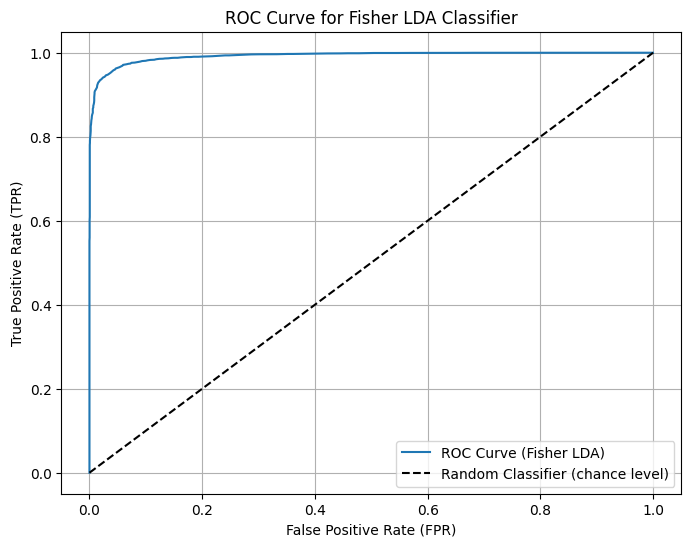

ROC Curve for Fisher LDA classifier plotted.


In [30]:
import matplotlib.pyplot as plt

# Set up a range of tau (threshold) values to sweep through
tau_values = np.linspace(np.min(projected_data), np.max(projected_data), num=500)

# Lists to store true positive and false positive rates for the ROC curve
tpr_values_lda = []  # True Positive Rate (P(D=1 | L=1))
fpr_values_lda = []  # False Positive Rate (P(D=1 | L=0))

# Iterate through each tau and compute TPR and FPR
for tau in tau_values:
    decisions_lda = (projected_data > tau).astype(int)

    # True positives: D=1 and L=1
    tp = np.sum((decisions_lda == 1) & (labels == 1))
    fn = np.sum((decisions_lda == 0) & (labels == 1))
    tpr_lda = tp / (tp + fn)  # True positive rate

    # False positives: D=1 and L=0
    fp = np.sum((decisions_lda == 1) & (labels == 0))
    tn = np.sum((decisions_lda == 0) & (labels == 0))
    fpr_lda = fp / (fp + tn)  # False positive rate

    tpr_values_lda.append(tpr_lda)
    fpr_values_lda.append(fpr_lda)

# Plot the ROC curve for Fisher LDA
plt.figure(figsize=(8, 6))
plt.plot(fpr_values_lda, tpr_values_lda, label='ROC Curve (Fisher LDA)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (chance level)')
plt.title('ROC Curve for Fisher LDA Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print the ROC curve details
print("ROC Curve for Fisher LDA classifier plotted.")


In [31]:
# Class priors
P_L0 = 0.35
P_L1 = 0.65

# Initialize an empty list to store the probability of error for each tau
errors_lda = []

# Calculate the error for each tau value
for i, tau in enumerate(tau_values):
    # False positive rate and false negative rate (1 - True positive rate)
    fpr_lda = fpr_values_lda[i]
    fnr_lda = 1 - tpr_values_lda[i]

    # Probability of error for this tau
    p_error_lda = fpr_lda * P_L0 + fnr_lda * P_L1
    errors_lda.append(p_error_lda)

# Find the index of the minimum error
min_error_idx_lda = np.argmin(errors_lda)
min_error_tau_lda = tau_values[min_error_idx_lda]
min_error_value_lda = errors_lda[min_error_idx_lda]

# Print the results
print("Step 5: Minimizing the Probability of Error with Fisher LDA")
print(f"The minimum probability of error (LDA) is {min_error_value_lda:.4f} at tau = {min_error_tau_lda:.4f}")


Step 5: Minimizing the Probability of Error with Fisher LDA
The minimum probability of error (LDA) is 0.0397 at tau = -0.7305


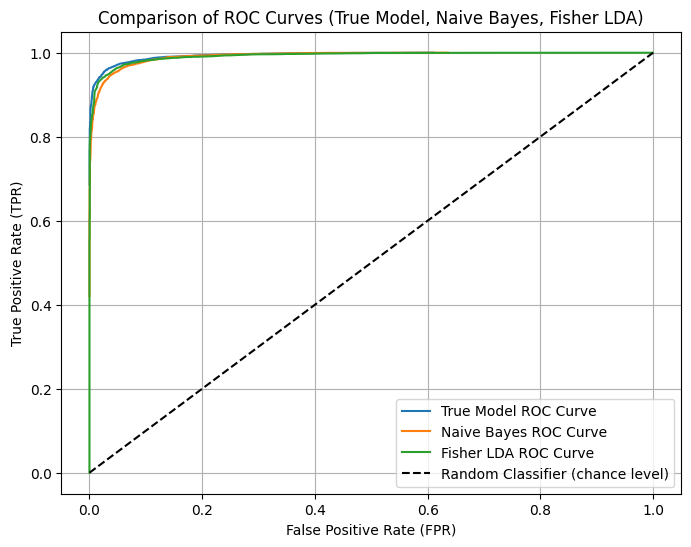

Comparison of Minimum Probability of Error
True Model: Minimum probability of error = 0.0358 at gamma = 0.4419
Naive Bayes Model: Minimum probability of error = 0.0438 at gamma = 0.4298
Fisher LDA Model: Minimum probability of error = 0.0397 at tau = -0.7305


In [33]:
# Plot ROC Curves for all three models (True Model, Naive Bayes, Fisher LDA) for comparison
plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, label='True Model ROC Curve')
plt.plot(fpr_values_naive, tpr_values_naive, label='Naive Bayes ROC Curve')
plt.plot(fpr_values_lda, tpr_values_lda, label='Fisher LDA ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (chance level)')
plt.title('Comparison of ROC Curves (True Model, Naive Bayes, Fisher LDA)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print minimum error comparison for all three models
print("Comparison of Minimum Probability of Error")
print(f"True Model: Minimum probability of error = {min(errors):.4f} at gamma = {gamma_values[np.argmin(errors)]:.4f}")
print(f"Naive Bayes Model: Minimum probability of error = {min_error_value_naive:.4f} at gamma = {min_error_gamma_naive:.4f}")
print(f"Fisher LDA Model: Minimum probability of error = {min_error_value_lda:.4f} at tau = {min_error_tau_lda:.4f}")


### LDA Classifier Performance Compared to True Model and Naive Bayes

#### Summary:
   - **True Model**: Optimal performance due to full knowledge of class distributions.
   - **Naive Bayes**: Suffers from feature independence assumption.
   - **Fisher LDA**: Provides a strong balance between simplicity and performance, offering a near-optimal solution while being computationally efficient.
